In [125]:
from warnings import deprecated

import numpy as np
import re
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

### Loading in the data
In these datasets, the target variable is the 'vote_average' column, which represents the average user rating for each movie. Our goal is to predict this value based on the other features in the dataset.

In [126]:
data = pd.read_csv('movies_training_set.csv')
# see what we have now
print(data.info())
# Exploratory analysis (brief)
# print the runtime statistics
# print(data['runtime'].describe())
# how many 0 values in the runtime
# print(f"Number of movies with 0 runtime: {(data['runtime'] == 0).sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22384 entries, 0 to 22383
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    22384 non-null  int64  
 1   title                 22384 non-null  object 
 2   vote_average          22384 non-null  float64
 3   vote_count            22384 non-null  int64  
 4   status                22384 non-null  object 
 5   release_date          22382 non-null  object 
 6   revenue               22384 non-null  int64  
 7   runtime               22384 non-null  int64  
 8   adult                 22384 non-null  bool   
 9   backdrop_path         22109 non-null  object 
 10  budget                22384 non-null  int64  
 11  homepage              6385 non-null   object 
 12  imdb_id               22340 non-null  object 
 13  original_language     22384 non-null  object 
 14  original_title        22384 non-null  object 
 15  overview           

### Plot the distribution of the target variable
It's important to understand the distribution of the target variable before training a model.

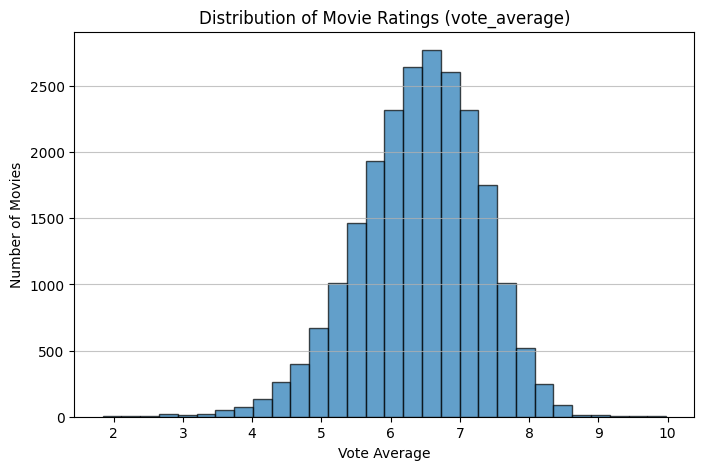

In [127]:
# Plot histogram of vote_average
plt.figure(figsize=(8, 5))
plt.hist(data['vote_average'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Movie Ratings (vote_average)')
plt.xlabel('Vote Average')
plt.ylabel('Number of Movies')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Make the training and testing sets
We will split the data into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate its performance.

In [128]:
# Drop rows with missing target values for training/validation split
data = data.dropna(subset=['vote_average'])
train_raw, val_raw = train_test_split(data, test_size=0.2, random_state=42)

### Preprocessing the data
We need to preprocess the data to make it suitable for training a machine learning model. This includes handling missing values, converting categorical variables into numerical format, and normalizing numerical features.
For this project, we are going to make the preprocessor a function that can be reused later on our testing set as well as any new data we want to predict on.

In [129]:
# --- helper: capture transform choices from training data ---
def fit_preprocessor(df):
    # df: labeled training rows (not modified)
    d = {}
    tmp = df.copy()
    # compute medians for numeric imputation (replace 0 -> NaN first)
    for col in ['budget', 'revenue', 'runtime']:
        vals = tmp[col].replace(0, np.nan)
        d.setdefault('medians', {})[col] = vals.median()
    # top lists for multi-hot features
    def top_n_from_col(series, splitter=',', n=10):
        counts = {}
        for val in series.dropna().astype(str):
            for item in val.split(splitter):
                item = item.strip()
                counts[item] = counts.get(item, 0) + 1
        return sorted(counts, key=counts.get, reverse=True)[:n]
    d['top_langs'] = top_n_from_col(tmp['original_language'], splitter=',', n=10)
    d['top_companies'] = top_n_from_col(tmp['production_companies'], splitter=',', n=10)
    d['top_countries'] = top_n_from_col(tmp['production_countries'], splitter=',', n=10)
    d['top_spoken'] = top_n_from_col(tmp['spoken_languages'], splitter=',', n=10)
    # genres: capture full set from training
    all_genres = set()
    for genres in tmp['genres'].dropna():
        for g in genres.split(','):
            all_genres.add(g.strip())
    d['genres'] = sorted(all_genres)
    return d

# --- apply the preprocessor choices consistently ---
def transform_preprocessor(df, preproc, test_mode=False):
    df = df.copy()
    if not test_mode:
        df = df.dropna(subset=['vote_average'])
    # drop unused columns
    df = df.drop(columns=['id','title','original_title','backdrop_path','homepage','poster_path','tagline','overview','imdb_id','status'], errors='ignore')
    # dates
    df['release_date_parsed'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['release_year'] = df['release_date_parsed'].dt.year
    df['release_month'] = df['release_date_parsed'].dt.month
    df['release_dayofweek'] = df['release_date_parsed'].dt.dayofweek
    df['release_quarter'] = df['release_date_parsed'].dt.quarter
    df = df.drop(columns=['release_date','release_date_parsed'], errors='ignore')

    # mark rows where date info was missing and impute date-derived features to avoid NaNs
    df['release_date_missing'] = df['release_year'].isna().astype(int)
    for col in ['release_year', 'release_month', 'release_dayofweek', 'release_quarter']:
        df[col] = df[col].fillna(-1).astype(int)

    # numeric imputation using training medians
    for col in ['budget','revenue','runtime']:
        df[col] = df[col].replace(0, np.nan)
        df[f'{col}_missing'] = df[col].isna().astype(int)
        df[col] = df[col].fillna(preproc['medians'][col])
    # original_language multi-hot using top_langs
    top_langs = preproc['top_langs']
    for lang in top_langs:
        df[f'lang_{lang}'] = df['original_language'].apply(
            lambda x: int(lang in [l.strip() for l in str(x).split(',')]) if pd.notna(x) else 0
        )
    df['lang_other'] = df['original_language'].apply(
        lambda x: int(any(l.strip() not in top_langs for l in str(x).split(','))) if pd.notna(x) else 0
    )
    df = df.drop(columns=['original_language'], errors='ignore')
    # genres multi-hot (use training set's genre list)
    for genre in preproc['genres']:
        df[f'genre_{genre}'] = df['genres'].apply(lambda x: int(genre in [g.strip() for g in str(x).split(',')]) if pd.notna(x) else 0)
    df = df.drop(columns=['genres'], errors='ignore')
    # production companies / countries / spoken -> top lists
    for company in preproc['top_companies']:
        df[f'prod_company_{company}'] = df['production_companies'].apply(lambda x: int(company in [c.strip() for c in str(x).split(',')]) if pd.notna(x) else 0)
    df = df.drop(columns=['production_companies'], errors='ignore')
    for country in preproc['top_countries']:
        df[f'prod_country_{country}'] = df['production_countries'].apply(lambda x: int(country in [c.strip() for c in str(x).split(',')]) if pd.notna(x) else 0)
    df = df.drop(columns=['production_countries'], errors='ignore')
    for lang in preproc['top_spoken']:
        df[f'spoken_lang_{lang}'] = df['spoken_languages'].apply(lambda x: int(lang in [c.strip() for c in str(x).split(',')]) if pd.notna(x) else 0)
    df = df.drop(columns=['spoken_languages'], errors='ignore')
    return df

### Following Function Unused
This is an earlier version of the preprocessing function that is now unused.

In [130]:
[[deprecated]]
def preprocess_data(df, test_mode=False):
    """
    Preprocess the movie dataset for modeling. If test_mode is True, do not drop rows with missing target values.
    """
    # First drop any rows with missing target values if not in test mode
    # if not test_mode:
    #     df = df.dropna(subset=['vote_average'])
    # We also don't need the 'id', 'title', 'original_title', 'backdrop_path', 'homepage', 'poster_path', 'tagline', 'overview' or 'imdb_id'
    # These columns have no bearing on the rating of the movie except for maybe the title and overview,
    # but those would require NLP techniques to extract useful information.
    # We are just going to ignore these columns for now as there is more important data in our set.
    df = df.drop(columns=['id', 'title', 'original_title', 'backdrop_path', 'homepage', 'poster_path', 'tagline', 'overview', 'imdb_id'])

    # Handle the 'status' column
    # print(df['status'].value_counts())
    # Since all of the movies are released, we can just drop this column
    df = df.drop(columns=['status'])

    # Handle the 'release_date' column
    # The release date is in the form of M/D/YYYY
    df['release_date_parsed'] = pd.to_datetime(df['release_date'], errors='coerce')

    # Extract fields
    df['release_year'] = df['release_date_parsed'].dt.year
    df['release_month'] = df['release_date_parsed'].dt.month
    df['release_dayofweek'] = df['release_date_parsed'].dt.dayofweek  # Monday=0
    df['release_quarter'] = df['release_date_parsed'].dt.quarter

    # create decade like "1990s" (keep NaN for missing years)
    # df['decade'] = df['release_year'].apply(
    #     lambda y: f"{int((y // 10) * 10)}s" if pd.notna(y) else np.nan
    # ).astype('category')

    # Drop the raw date column
    df = df.drop(columns=['release_date', 'release_date_parsed'])

    # Time to handle the 'budget' and 'revenue' columns
    # First replace 0 with NaN
    df['budget'] = df['budget'].replace(0, np.nan)
    df['revenue'] = df['revenue'].replace(0, np.nan)

    # Add a missing indicator for budget and revenue
    df['budget_missing'] = df['budget'].isna().astype(int)
    df['revenue_missing'] = df['revenue'].isna().astype(int)
    # Fill missing values with median
    df['budget'] = df['budget'].fillna(df['budget'].median())
    df['revenue'] = df['revenue'].fillna(df['revenue'].median())

    # Do the same for the 'runtime' column
    df['runtime'] = df['runtime'].replace(0, np.nan)
    df['runtime_missing'] = df['runtime'].isna().astype(int)
    df['runtime'] = df['runtime'].fillna(df['runtime'].median())

    # Handle the 'original_language' column
    # print(df['original_language'].value_counts())
    # Multi-hot encode original_language
    all_langs = {}
    for langs in df['original_language'].dropna().astype(str):
        for lang in re.split(r'\s*,\s*', langs):
            all_langs[lang] = all_langs.get(lang, 0) + 1
    top_langs = sorted(all_langs, key=all_langs.get, reverse=True)[:10]
    for lang in top_langs:
        df[f'lang_{lang}'] = df['original_language'].apply(
            lambda x: int(lang in re.split(r'\s*,\s*', str(x))) if pd.notna(x) else 0
        )
    # indicator for any non-top language present
    df['lang_other'] = df['original_language'].apply(
        lambda x: int(any(l not in top_langs for l in re.split(r'\s*,\s*', str(x)))) if pd.notna(x) else 0
    )
    df = df.drop(columns=['original_language'])

    # Handle the 'genres' column
    # This data is a comma-separated list of genres
    # Flatten and list all unique genres
    all_genres = set()
    for genres in df['genres'].dropna():
        for genre in genres.split(','):
            all_genres.add(genre.strip())
    # print(list(all_genres))
    # There are 20 unique genres, we will one-hot encode them at the cost of some sparsity
    for genre in all_genres:
        df[f'genre_{genre}'] = df['genres'].apply(lambda x: int(genre in x.split(',')) if pd.notna(x) else 0)
    # Drop the original genres column
    df = df.drop(columns=['genres'])

    # Handle the 'production_companies' column
    # Similar to genres, we will one-hot encode the top 10 production companies
    all_companies = {}
    for companies in df['production_companies'].dropna():
        for company in companies.split(','):
            company = company.strip()
            all_companies[company] = all_companies.get(company, 0) + 1
    top_companies = sorted(all_companies, key=all_companies.get, reverse=True)[:10]
    for company in top_companies:
        df[f'prod_company_{company}'] = df['production_companies'].apply(lambda x: int(company in x.split(',')) if pd.notna(x) else 0)
    # Drop the original production_companies column
    df = df.drop(columns=['production_companies'])

    # 'production_countries' column also has a list of countries
    # We will one-hot encode the top 10 production countries
    all_countries = {}
    for countries in df['production_countries'].dropna():
        for country in countries.split(','):
            country = country.strip()
            all_countries[country] = all_countries.get(country, 0) + 1
    top_countries = sorted(all_countries, key=all_countries.get, reverse=True)[:10]
    for country in top_countries:
        df[f'prod_country_{country}'] = df['production_countries'].apply(lambda x: int(country in x.split(',')) if pd.notna(x) else 0)
    # Drop the original production_countries column
    df = df.drop(columns=['production_countries'])

    # 'spoken_languages' column also has a list of languages
    # We will multi-hot encode the top 10 spoken languages
    all_spoken_languages = {}
    for languages in df['spoken_languages'].dropna():
        for language in languages.split(','):
            language = language.strip()
            all_spoken_languages[language] = all_spoken_languages.get(language, 0) + 1
    top_spoken_languages = sorted(all_spoken_languages, key=all_spoken_languages.get, reverse=True)[:10]
    for language in top_spoken_languages:
        df[f'spoken_lang_{language}'] = df['spoken_languages'].apply(lambda x: int(language in x.split(',')) if pd.notna(x) else 0)
    # Drop the original spoken_languages column
    df = df.drop(columns=['spoken_languages'])

    # At this point the only column left is the keywords column, which may be more impactful so we need to handle it carefully
    # We will do this in its own functions

    # Finally return the cleaned dataframe
    return df

### TF-IDF Vectorization of Keywords
We will create a separate function to handle the 'keywords' column using TF-IDF vectorization.

In [131]:
def _kw_tokenizer(s):
    return [kw.strip().lower() for kw in str(s).split(',') if kw.strip()]

def fit_tfidf_keywords(df, column='keywords', max_features=100):
    """
    Fit a TfidfVectorizer that tokenizes on commas and return
    (vectorizer, df_with_tfidf_columns).
    """
    vec = TfidfVectorizer(tokenizer=_kw_tokenizer, token_pattern=None, max_features=max_features)
    corpus = df[column].fillna('').astype(str)
    X = vec.fit_transform(corpus)
    cols = [f"kw_{t}" for t in vec.get_feature_names_out()]
    tfidf_df = pd.DataFrame(X.toarray(), columns=cols, index=df.index)
    out = pd.concat([df.drop(columns=[column]), tfidf_df], axis=1)
    return vec, out

def transform_tfidf_keywords(df, vectorizer, column='keywords'):
    """
    Transform new dataframe `df` using previously fitted `vectorizer`.
    """
    corpus = df[column].fillna('').astype(str)
    X = vectorizer.transform(corpus)
    cols = [f"kw_{t}" for t in vectorizer.get_feature_names_out()]
    tfidf_df = pd.DataFrame(X.toarray(), columns=cols, index=df.index)
    out = pd.concat([df.drop(columns=[column]), tfidf_df], axis=1)
    return out

### Apply preprocessing
Now we apply the preprocessing function to our dataset.

In [132]:
preproc = fit_preprocessor(train_raw)
train = transform_preprocessor(train_raw, preproc, test_mode=False)
val = transform_preprocessor(val_raw, preproc, test_mode=False)
vec, train = fit_tfidf_keywords(train, column='keywords', max_features=100)
val = transform_tfidf_keywords(val, vec, column='keywords')
# There are some nan values that appeared after processing, debug print which columns they are in
# nan_cols = train.columns[train.isna().any()].tolist()
# print (f"Columns with NaN values after preprocessing: {nan_cols}")
print(f"Training data shape after preprocessing: {train.shape}")
print(f"Validation data shape after preprocessing: {val.shape}")
print(f"Features used for training: {train.drop(columns=['vote_average']).columns.tolist()}")

Training data shape after preprocessing: (17907, 175)
Validation data shape after preprocessing: (4477, 175)
Features used for training: ['vote_count', 'revenue', 'runtime', 'adult', 'budget', 'popularity', 'release_year', 'release_month', 'release_dayofweek', 'release_quarter', 'release_date_missing', 'budget_missing', 'revenue_missing', 'runtime_missing', 'lang_en', 'lang_fr', 'lang_it', 'lang_ja', 'lang_es', 'lang_de', 'lang_hi', 'lang_ko', 'lang_zh', 'lang_ru', 'lang_other', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'prod_company_Warner Bros. Pictures', 'prod_company_Universal Pictures', 'prod_company_Paramount', 'prod_company_20th Century Fox', 'prod_company_Columbia Pictures', 'prod_company_Canal+', 

### Training the Model
We will use a Gradient Boosting Regressor to train our model on the preprocessed training data.

In [133]:
Y_train = train['vote_average']
X_train = train.drop(columns=['vote_average'])
Y_val = val['vote_average']
X_val = val.drop(columns=['vote_average'])

# Current best hyperparameters after tuning are n_estimators=200, learning_rate=0.05, max_depth=8
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=9, random_state=42)
model.fit(X_train, Y_train)


,loss,'squared_error'
,learning_rate,0.05
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,9
,min_impurity_decrease,0.0
,init,None


### Evaluating the Model
We will evaluate the model's performance on the validation set using metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R2).

In [134]:
preds = model.predict(X_val)
mse = mean_squared_error(Y_val, preds)
mae = mean_absolute_error(Y_val, preds)
r2 = r2_score(Y_val, preds)
print(f"Validation MSE: {mse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation R2: {r2:.4f}")

Validation MSE: 0.3347
Validation MAE: 0.4334
Validation R2: 0.5717


### Predict on New Data
We can now use the trained model to make predictions on new, unseen data.

In [135]:
# Load new data
new_data = pd.read_csv('movies_testing_set.csv')
# Preprocess new data
new_data_processed = transform_preprocessor(new_data, preproc, test_mode=True)
new_data_processed = transform_tfidf_keywords(new_data_processed, vec, column='keywords')
# Make predictions
new_preds = model.predict(new_data_processed)
# Save the predictions to a CSV file as id, title, predicted_vote_average
output = new_data[['id', 'title']].copy()
output['predicted_vote_average'] = new_preds
output.to_csv('movie_rating_predictions.csv', index=False)

### Prediction Distribution
We can visualize the distribution of the predicted ratings for the new data.
If it is a random sampling, the distribution should be similar to the training/validation set.

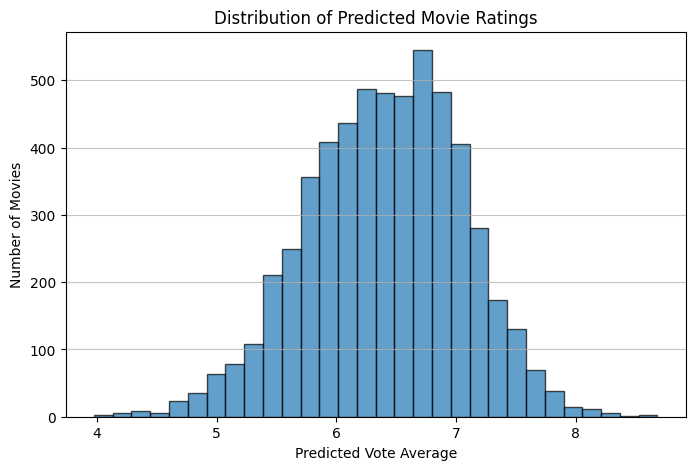

In [136]:
# Show a distribution of the predicted ratings
plt.figure(figsize=(8, 5))
plt.hist(new_preds, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Predicted Movie Ratings')
plt.xlabel('Predicted Vote Average')
plt.ylabel('Number of Movies')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Feature Importance
We can also look at the feature importances to understand which features were most influential in the model's predictions.

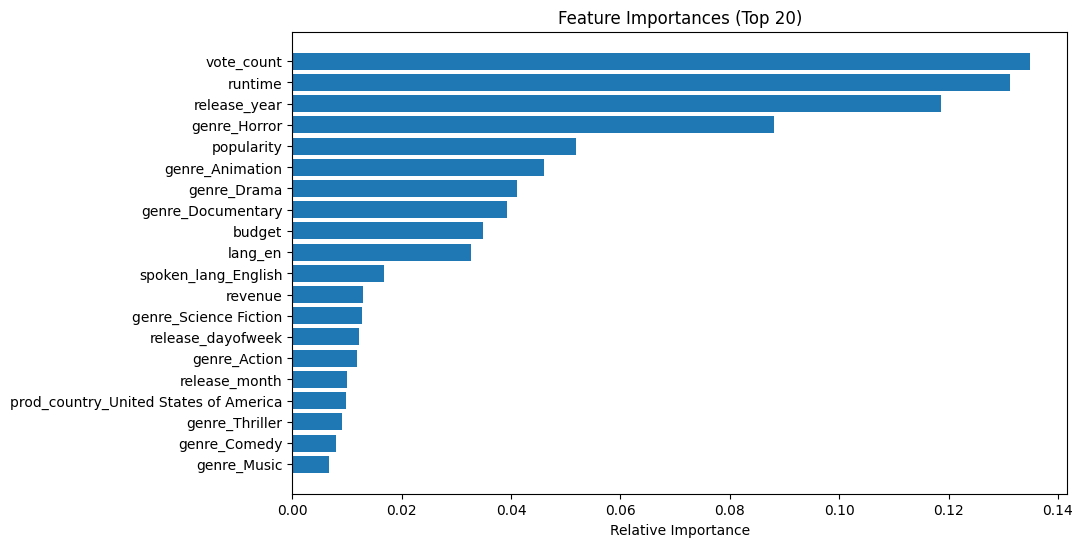

In [137]:
# Get feature importances
importances = model.feature_importances_
feature_names = X_train.columns
# Output feature importances as a bar chart (the first 20 features)
indices = np.argsort(importances)[-20:]  # top 20 features
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Top 20)")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Display the tree structure

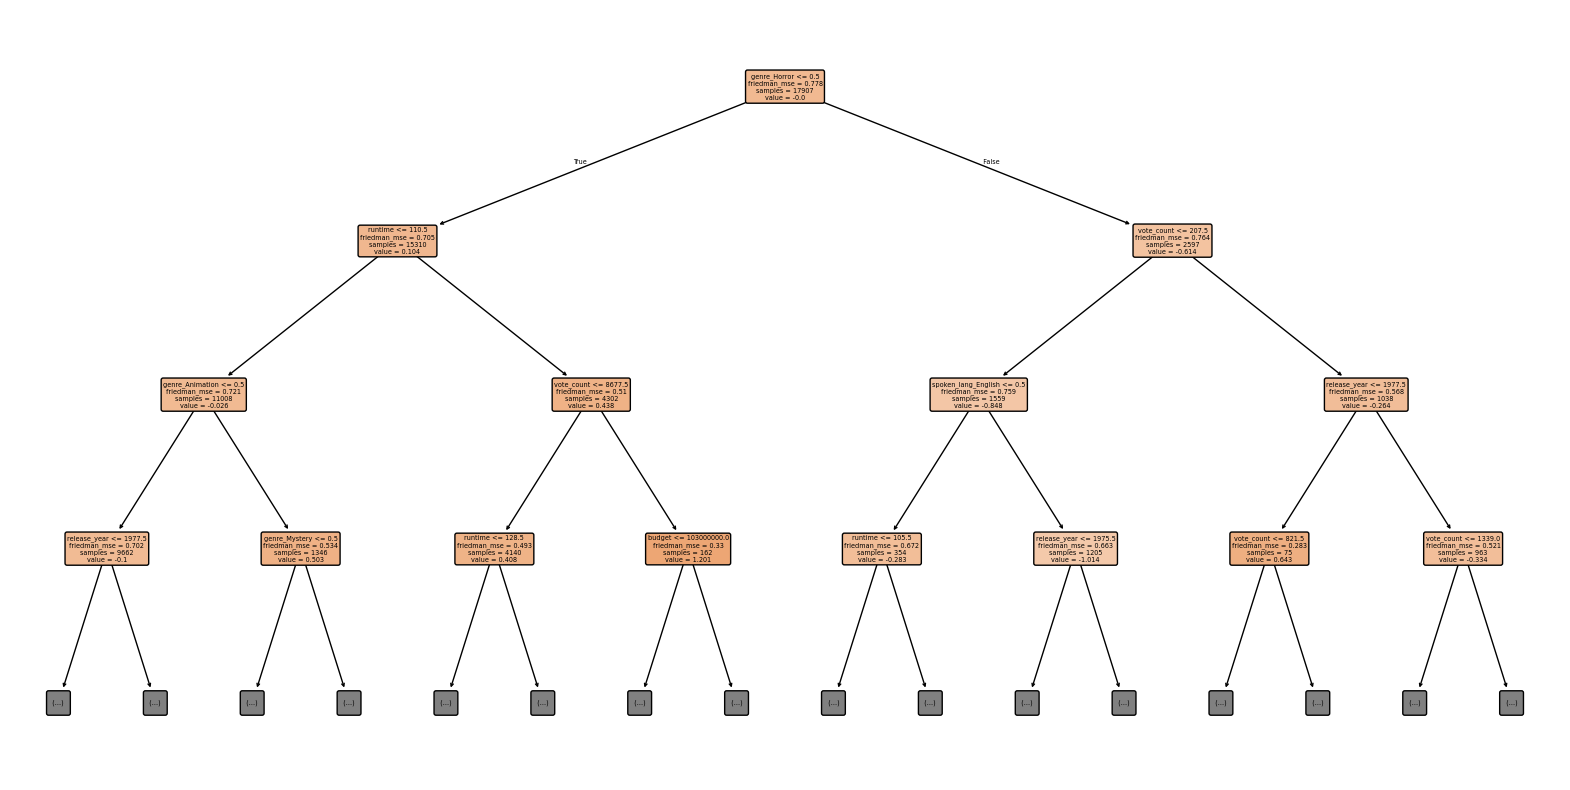

In [138]:
# Visualize one of the trees in the ensemble
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0, 0], filled=True, feature_names=X_train.columns, rounded=True, max_depth=3)
plt.show()

### Experimental
This section is for any experimental code or further analysis.

In [139]:
# Convert pandas → torch tensor
# convert bool to int
for col in X_train.select_dtypes(include=['bool']).columns:
    X_train[col] = X_train[col].astype(int)
for col in X_val.select_dtypes(include=['bool']).columns:
    X_val[col] = X_val[col].astype(int)
# 2) scale features and target (stable optimization)
scaler_X = StandardScaler()
Xtr_np = scaler_X.fit_transform(X_train.to_numpy(dtype=np.float32))
Xv_np  = scaler_X.transform(X_val.to_numpy(dtype=np.float32))

# scale target (optional but recommended)
y_mean = Y_train.mean()
y_std  = Y_train.std() if Y_train.std() > 0 else 1.0
Ytr_np = ((Y_train - y_mean) / y_std).to_numpy(dtype=np.float32).reshape(-1, 1)
Yv_np  = ((Y_val   - y_mean) / y_std).to_numpy(dtype=np.float32).reshape(-1, 1)

# 3) convert to tensors using from_numpy (avoids extra copies)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Xtr = torch.from_numpy(Xtr_np).to(device)
Ytr = torch.from_numpy(Ytr_np).to(device)
Xv  = torch.from_numpy(Xv_np).to(device)
Yv  = torch.from_numpy(Yv_np).to(device)

In [140]:
BATCH_SIZE = 64
train_ds = TensorDataset(Xtr, Ytr)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# 5) model, loss, optimizer
input_dim = Xtr.shape[1]

model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
).to(device)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,      # a bit higher to escape shallow minima
    weight_decay=1e-5
)

# LR scheduler on validation loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=8,      # wait longer before reducing LR
    min_lr=1e-6,
)

In [141]:
# 6) training loop with more epochs and larger patience
EPOCHS = 400
best_val = float("inf")
patience = 25         # allow long training overnight
counter = 0
best_path = "best_model.pt"

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    n_seen = 0

    for Xb, Yb in train_loader:
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, Yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        batch_n = Xb.shape[0]
        total_loss += loss.item() * batch_n
        n_seen += batch_n

    train_loss = total_loss / max(1, n_seen)

    # validation (no grad)
    model.eval()
    with torch.no_grad():
        val_preds = model(Xv)
        val_loss = criterion(val_preds, Yv).item()

    # step scheduler with validation loss
    scheduler.step(val_loss)

    # early stopping logic
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        counter = 0
        torch.save(model.state_dict(), best_path)
    else:
        counter += 1

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train Loss: {train_loss:.6f} | "
        f"Val Loss: {val_loss:.6f} | "
        f"Best Val: {best_val:.6f} | "
        f"Patience: {counter}/{patience}"
    )

    if counter >= patience:
        print("Early stopping triggered.")
        break

# load best model before computing metrics in original target scale
model.load_state_dict(torch.load(best_path))

Epoch 001 | Train Loss: 0.701838 | Val Loss: 0.585033 | Best Val: 0.585033 | Patience: 0/25
Epoch 002 | Train Loss: 0.558251 | Val Loss: 0.550850 | Best Val: 0.550850 | Patience: 0/25
Epoch 003 | Train Loss: 0.514522 | Val Loss: 0.535874 | Best Val: 0.535874 | Patience: 0/25
Epoch 004 | Train Loss: 0.483891 | Val Loss: 0.533413 | Best Val: 0.533413 | Patience: 0/25
Epoch 005 | Train Loss: 0.460533 | Val Loss: 0.526667 | Best Val: 0.526667 | Patience: 0/25
Epoch 006 | Train Loss: 0.440351 | Val Loss: 0.526895 | Best Val: 0.526667 | Patience: 1/25
Epoch 007 | Train Loss: 0.425051 | Val Loss: 0.524455 | Best Val: 0.524455 | Patience: 0/25
Epoch 008 | Train Loss: 0.408889 | Val Loss: 0.520805 | Best Val: 0.520805 | Patience: 0/25
Epoch 009 | Train Loss: 0.395657 | Val Loss: 0.530766 | Best Val: 0.520805 | Patience: 1/25
Epoch 010 | Train Loss: 0.384675 | Val Loss: 0.527032 | Best Val: 0.520805 | Patience: 2/25
Epoch 011 | Train Loss: 0.373528 | Val Loss: 0.532721 | Best Val: 0.520805 | Pat

<All keys matched successfully>

In [142]:
# 7) compute metrics in original target scale
model.eval()
with torch.no_grad():
    val_preds_scaled = model(Xv).cpu().numpy().reshape(-1)
    val_preds = val_preds_scaled * y_std + y_mean
    Yv_orig = (Yv.cpu().numpy().reshape(-1) * y_std) + y_mean  # or use Y_val_f directly

mse = mean_squared_error(Yv_orig, val_preds)
mae = mean_absolute_error(Yv_orig, val_preds)
r2  = r2_score(Yv_orig, val_preds)
print(f"Final Validation MSE: {mse:.4f}")
print(f"Final Validation MAE: {mae:.4f}")
print(f"Final Validation R2: {r2:.4f}")

Final Validation MSE: 0.4050
Final Validation MAE: 0.4863
Final Validation R2: 0.4817
